In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [3]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


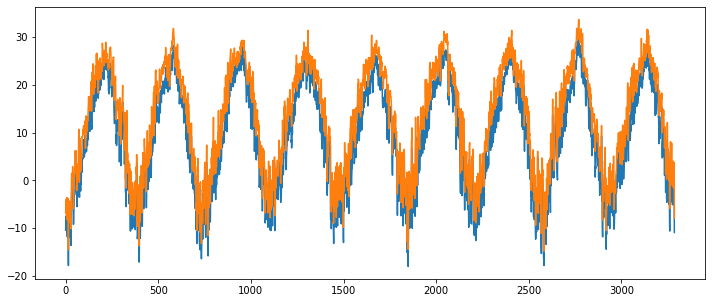

In [4]:
min_data = temp[['min']]
temp_data = temp[['avg']]
plt.figure(figsize=(12,5))
plt.plot(min_data)
plt.plot(temp_data)
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(-1,1))
temp_data = scaler.fit_transform(temp_data)

print(type(temp_data))

<class 'numpy.ndarray'>


In [6]:
temp.date[2556]

'2017-12-31'

In [7]:
train=temp_data[:2557]
test = temp_data[2557:]

In [8]:
print((3287-2557)/180)
print(len(train))
print(len(test))
print(361-181)

4.055555555555555
2557
730
180


In [9]:
def create_dataset(time_data, look_back=1):
  data_X, data_y=[],[]

  for i in range(len(time_data)- look_back):  # train =2557/ test=730
    data_X.append(time_data[i:(i+look_back), 0])  # [0:180] / [1:181] / [2:182]
    data_y.append(time_data[i+look_back, 0])      # [180] / [181] / [182]

  return np.array(data_X), np.array(data_y)



In [10]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

In [11]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

In [12]:
from keras import backend as K

K.clear_session()

In [13]:
model = Sequential(name='Stacked_LSTM')
model.add(LSTM(64, input_shape=(None,1), return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='tanh'))

model.summary()

model.compile(loss='mse', optimizer='adam')

Model: "Stacked_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
Hist = model.fit(train_X, train_y, epochs=50, batch_size=180, validation_data=(test_X, test_y))

Epoch 1/50
14/14 [==============================] - 35s 98ms/step - loss: 0.1606 - val_loss: 0.0250
Epoch 2/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0244 - val_loss: 0.0189
Epoch 3/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0206 - val_loss: 0.0180
Epoch 4/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0203 - val_loss: 0.0168
Epoch 5/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0189 - val_loss: 0.0163
Epoch 6/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0184 - val_loss: 0.0160
Epoch 7/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0180 - val_loss: 0.0158
Epoch 8/50
14/14 [==============================] - 0s 22ms/step - loss: 0.0175 - val_loss: 0.0154
Epoch 9/50
14/14 [==============================] - 0s 24ms/step - loss: 0.0170 - val_loss: 0.0151
Epoch 10/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0167 - val_loss: 0.0149
Epoch 11

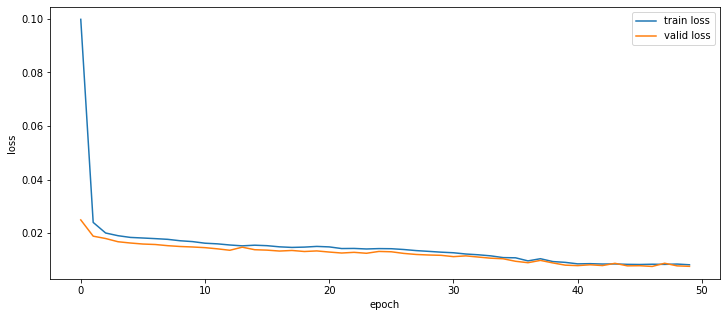

In [15]:
plt.figure(figsize=(12,5))
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'valid loss'], loc='upper right')
plt.show()

In [16]:
trainScore = model.evaluate(train_X, train_y, verbose=0)
testScore = model.evaluate(test_X, test_y, verbose=0)

print('train score:', trainScore)
print('test score:', testScore)

train score: 0.008013381622731686
test score: 0.00764953950420022


<class 'numpy.ndarray'> (180, 1)
<class 'numpy.ndarray'>
(1, 180, 1)


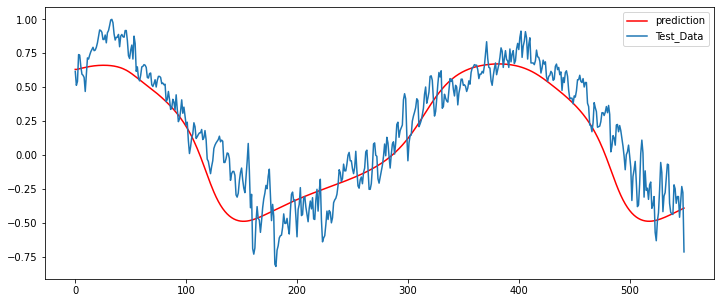

In [30]:
look_ahead = 550
xhat = test_X[0]
print(type(xhat), xhat.shape)
print(type(np.array([xhat])))
print(np.array([xhat]).shape)

predictions= np.zeros((look_ahead, 1))

for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=1) # model.predict를 위한 input인 test_X의 형태 = [550,180,1]
  # prediction = y 예측값
  predictions[i] = prediction  # np.zeros에서 하나씩 y 예측값(predict) 채워나감
  
  xhat = np.vstack([xhat[1:], prediction])

plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label='Test_Data')
plt.legend()
plt.show()